# Prediction of Tennis Match Results Using Classification Model with K-Nearest Neighbours Algorithm

## Introduction

ATP (Association of Tennis Professionals) and WTA (Women's Tennis Association) rankings are based on the points earned by players in ATP or WTA-certified events over the preceding 52-weeks. Each tennis match includes 2 to 3 sets and each set has at least 6 games. Whoever starts serving continues to serve until that game is over. Games are scored starting from 0 to 40, then game point, which wins the game. 

Our project will answer whether a professional tennis player will win or lose the match. The dataset contains 6866 rows of data from tennis matches for top 500 players from 2017- 2019. The dataset includes the tournament's ID, name, level, date and draw size, and the match number, score and time. Also has winners and losers ID, seed, name, age, height, hand used, country, rank, rank points, and their aces, serve points, break points faced and saved in the match. Age of players is calculated when they’re in the match and reported in decimals. Rank is based on the player’s ATP/WTA rank as of the tournament date. We will omit all rows with missing data after selecting our predictors.

## Preliminary exploratory data analysis

In [37]:
library(tidyverse)
library(repr)
library(tidymodels)

In [38]:
set.seed(123)

# Reading and Wrangling Data

atp_data <- read_csv("https://raw.githubusercontent.com/EllaShi7/Group-42-Project-DSCI-100-2022w2/main/atp2017-2019.csv") |>
  select(winner_age, loser_age, winner_rank, loser_rank, w_1stWon, l_1stWon) |> 
  na.omit()

win <- rep(c("win"), times = nrow(atp_data))
atp_data_win <- cbind(atp_data, win) |>
  select(win, winner_age, winner_rank, w_1stWon)
colnames(atp_data_win) <- c("result", "age","rank", "first_svpt_won")

lose <- rep(c("lose"), times = nrow(atp_data))
atp_data_lose <- cbind(atp_data, lose) |>
  select(lose, loser_age, loser_rank, l_1stWon)
colnames(atp_data_lose) <- c("result", "age","rank", "first_svpt_won")

data <- rbind(atp_data_win, atp_data_lose) |>
  mutate(result = as_factor(result))

# Splitting Dataset

data_split <- initial_split(data, prop = 0.75, strata = result)  
atp_train <- training(data_split)   
atp_test <- testing(data_split)

atp_train
atp_test  

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,result,age,rank,first_svpt_won
,<fct>,<dbl>,<dbl>,<dbl>
6771,lose,22.88569,16,34
6772,lose,33.70568,239,36
6775,lose,28.01095,18,46
6776,lose,26.40383,185,40
6779,lose,24.69815,72,30
6783,lose,23.97810,14,35
6786,lose,22.72416,146,34
6787,lose,25.98494,154,17
6788,lose,19.40589,147,18


,result,age,rank,first_svpt_won
,<fct>,<dbl>,<dbl>,<dbl>
4,win,33.70568,239,34
8,win,33.70568,239,30
17,win,24.69815,72,23
22,win,23.67967,35,63
23,win,31.88227,40,40
28,win,30.71321,24,52
29,win,31.61123,1,41
32,win,26.85284,21,31
34,win,28.50376,48,48


In [39]:
# Summary Tables for Our Dataset - Code

num_obs <- nrow(atp_train)

atp_train_results <- atp_train |>
                     group_by(result) |>
                     summarize(count = n(), percentage = n()/num_obs * 100)


atp_train_wins <- filter(atp_train, result == "win")
atp_train_losses <- filter(atp_train, result == "lose")

atp_train_wins_averages <- atp_train_wins |>
                      mutate(average_age = mean(age)) |>
                      mutate(average_rank = mean(rank)) |>
                      mutate(average_first_svpt_won = mean(first_svpt_won)) |>
                      select(result, average_age, average_rank, average_first_svpt_won) |>
                      slice(1)

atp_train_losses_averages <- atp_train_losses |>
                      mutate(average_age = mean(age)) |>
                      mutate(average_rank = mean(rank)) |>
                      mutate(average_first_svpt_won = mean(first_svpt_won)) |>
                      select(result, average_age, average_rank, average_first_svpt_won) |>
                      slice(1)

atp_train_averages <- rbind(atp_train_wins_averages, atp_train_losses_averages)

atp_train_missing_rows <- data.frame(missing_rows = sum(is.na(atp_train)))


atp_train_results 

atp_train_averages 

atp_train_missing_rows


result,count,percentage
<fct>,<int>,<dbl>
win,5077,50
lose,5077,50


result,average_age,average_rank,average_first_svpt_won
<fct>,<dbl>,<dbl>,<dbl>
win,27.58609,57.99350,37.85759
lose,27.49127,82.82509,33.97420


missing_rows
<int>
0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



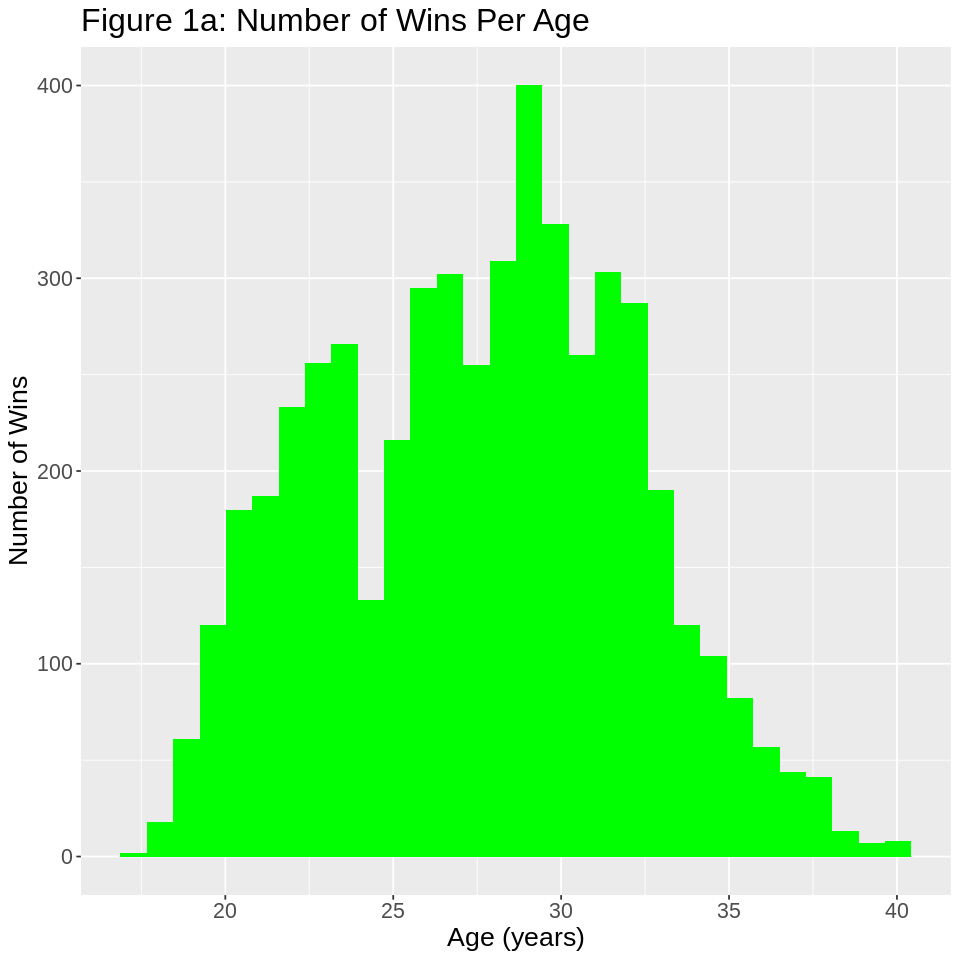

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 154 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


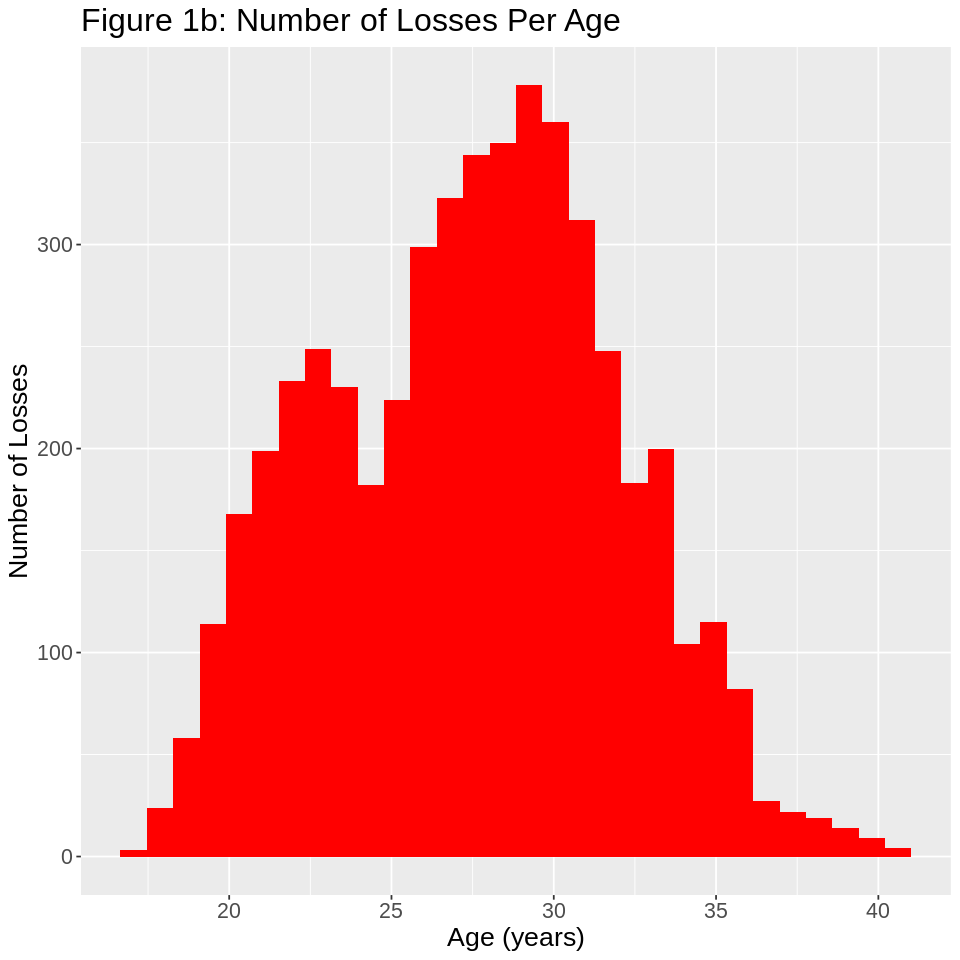

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 330 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


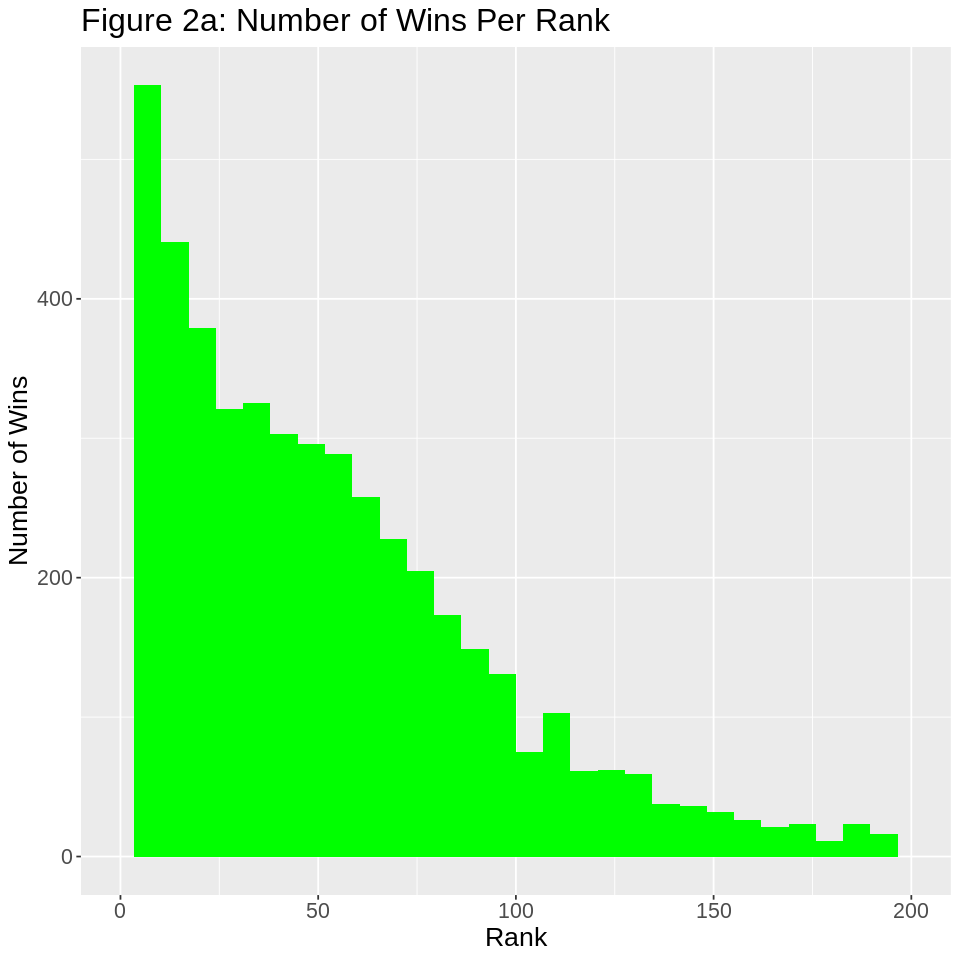

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


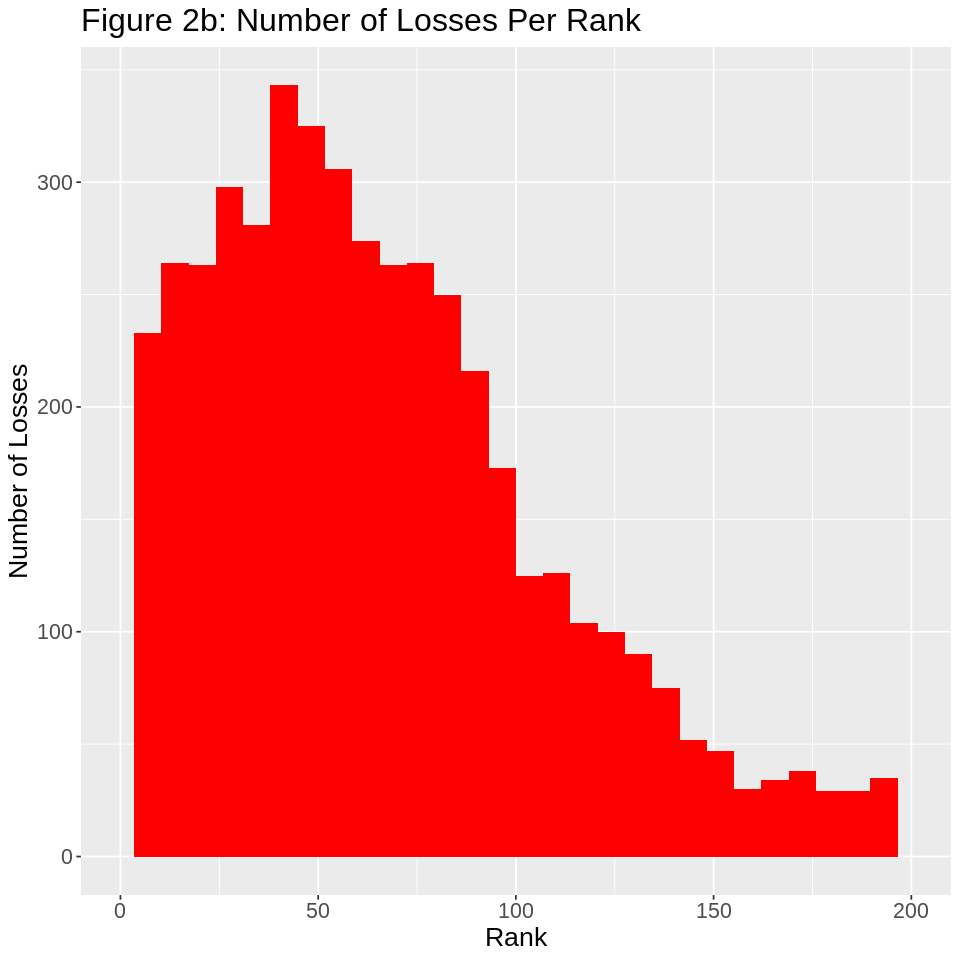

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 6 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


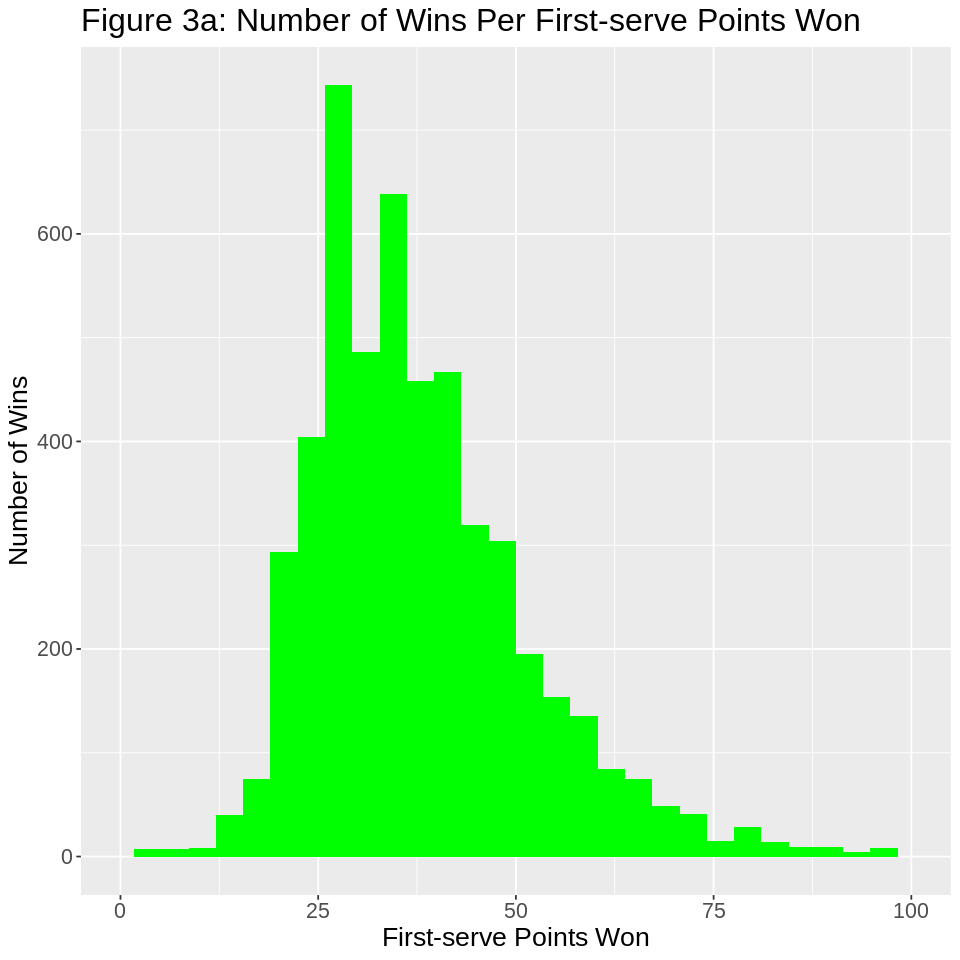

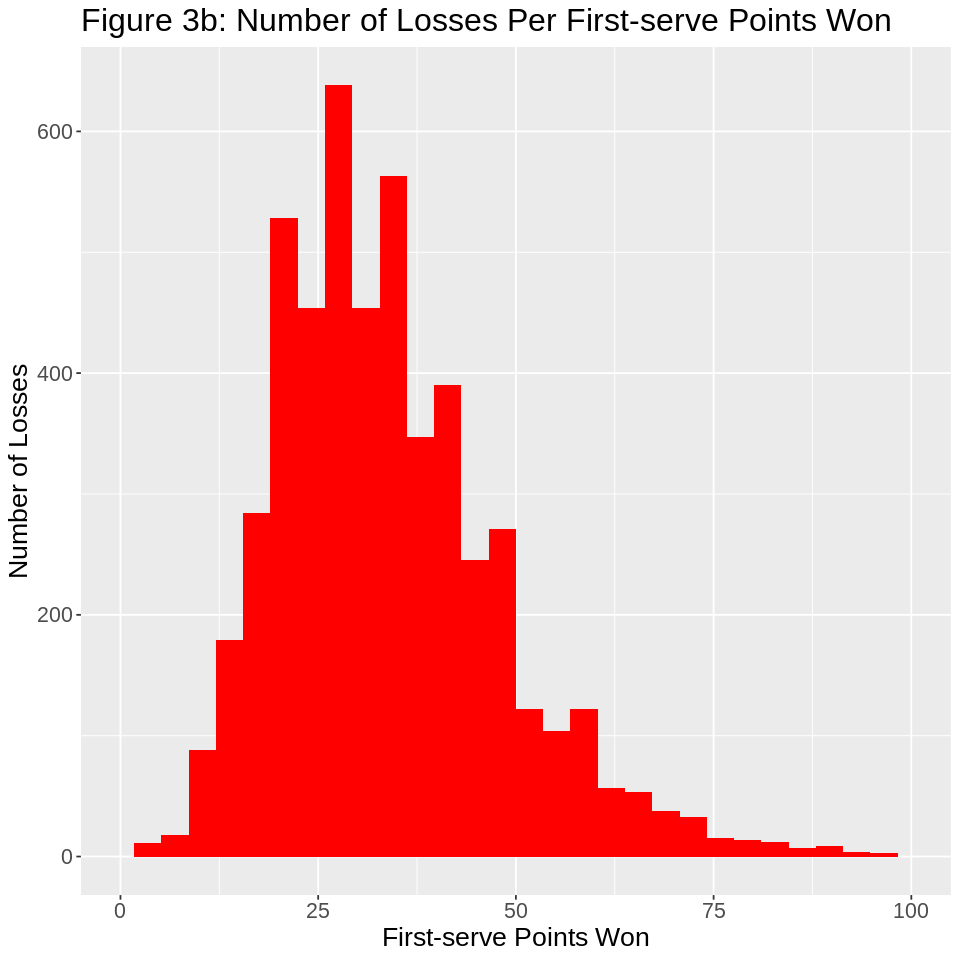

In [28]:
# Visualization of dataset - Code
options(repr.plot.height = 8, repr.plot.width = 8)

# Predictor 1 (Age) vs Result

atp_train_wins <- filter(atp_train, result == "win")

wins_per_age <- ggplot(atp_train_wins, aes(x = age)) +
                   geom_histogram(fill = "green") +
                   labs(x = "Age (years)", y = "Number of Wins") +
                   ggtitle("Figure 1a: Number of Wins Per Age") +
                   theme(text = element_text(size = 16))
                   
wins_per_age

atp_train_losses <- filter(atp_train, result == "lose")


losses_per_age <-  ggplot(atp_train_losses, aes(x = age)) +
                   geom_histogram(fill = "red") +
                   labs(x = "Age (years)", y = "Number of Losses") +
                   ggtitle("Figure 1b: Number of Losses Per Age") +
                   theme(text = element_text(size = 16))

losses_per_age


# Predictor 2 (Rank) vs Result

wins_per_rank <- ggplot(atp_train_wins, aes(x = rank)) +
                   geom_histogram(fill = "green") +
                   labs(x = "Rank", y = "Number of Wins") +
                   xlim(0,200) +
                   ggtitle("Figure 2a: Number of Wins Per Rank") +
                   theme(text = element_text(size = 16))
                   
wins_per_rank


losses_per_age <-  ggplot(atp_train_losses, aes(x = rank)) +
                   geom_histogram(fill = "red") +
                   labs(x = "Rank", y = "Number of Losses") +
                   xlim(0,200) +
                   ggtitle("Figure 2b: Number of Losses Per Rank") +
                   theme(text = element_text(size = 16))               

losses_per_age


# Predictor 3 (First-serve points Won) vs Result

wins_per_1stwon <- ggplot(atp_train_wins, aes(x = first_svpt_won)) +
                   geom_histogram(fill = "green") +
                   labs(x = "First-serve Points Won", y = "Number of Wins") +
                   xlim(0,100) +
                   ggtitle("Figure 3a: Number of Wins Per First-serve Points Won") +
                   theme(text = element_text(size = 16))

wins_per_1stwon


losses_per_1stwon <- ggplot(atp_train_losses, aes(x = first_svpt_won)) +
                   geom_histogram(fill = "red") +
                   labs(x = "First-serve Points Won", y = "Number of Losses") +
                   xlim(0,100) +
                   ggtitle("Figure 3b: Number of Losses Per First-serve Points Won") +
                   theme(text = element_text(size = 16))

losses_per_1stwon


## Methods

We will use winners’ and losers’ age , rank, and first-serve points won in the match as the variables for prediction. Figure 1a and 1b indicates a reduction of wins for players around 24 to 25 years old, and 29 year old players contribute the most wins. Also, 36.25 to 38 year-old players have double the amount of wins than losses. Figures 2a and 2b show players ranked in the top 25 have a significantly higher number of wins than losses while players ranked from 100 onwards had significantly more losses than wins. From the summary table, the average rank of the winner is also higher than the player that loses. Higher first-serve points won relates to more number of wins than losses, especially after 37 points as in Figure 3a and 3b. Winners of matches also have a higher average first-serve point than losers of the match shown in the summary table. Thus, rank and first-serve points will serve as stronger predictors and the age predictor could help differentiate when the other two predictors have similar values.

We will conduct our data analysis by building a binary classification model with K-nearest neighbours algorithm using the “tidymodels” R package. Prediction of new observations will be based on a majority vote of the closest neighbouring classes. First, we will set the seed then split the wrangled dataset randomly (but reproducible) to create a training and testing set with strata argument as the categorical label variable “result”. Next, parameter K will be determined through 10-fold cross-validation by splitting the training data into 10 training and validation subsets. Then, we will create a recipe using training data which includes centering and scaling all predictors. Following by creating a KNN model specification with neighbors equal to tune(). To create our data analysis workflow, we add our recipe and model specification and use tune_grid function on the training/validation subsets to estimate our classifier’s accuracy for K values of 1-100. Afterwards, we choose the K value with the highest accuracy estimate by plotting accuracy versus K. Subsequently, we will create a new model specification with the best K value, and retrain our classifier using training data. Finally, we predict the “result” label in the testing set to evaluate the estimated accuracy of our classifier.

Results will be visualized through a series of scatter plots – rank versus first-serve points won, rank versus age, first-serve points won versus age – with data points of wins and losses categorized by different colours and where the background colour indicates the prediction of our classifier. 

## Expected outcomes and significance

We expect to find that tennis players with higher ranking and higher first-serve points won will most likely be predicted to win the match. Tennis match result predictions by this classifier could help decide whether or not to place a bet, be used for coaches to evaluate a player's performance, and for media channels to provide more insightful coverage of a sporting tournament. We could further explore whether or not a specific tennis stroke or a strategy is working, and lead to which type of training is required to equip a player. These data may help develop a player’s skills and foster their growth with a suitable approach.